<a href="https://colab.research.google.com/github/DesiPilla/demographics-voterid-turnout/blob/master/Group_2_Data_Wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Import packages

Import all necessary packages for this project.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install geopandas
import geopandas as gp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sn

import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 931kB 2.9MB/s 
     |████████████████████████████████| 14.7MB 257kB/s 
     |████████████████████████████████| 10.9MB 48.1MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Collect Geospatial data

Collect all geospatial datasets. This includes shapefiles for each county and state in the US. The geospatial files are simplified representations of selected geographic areas from the [Census Bureau’s MAF/TIGER](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html) geographic database.

### State Data

Collect and clean all geospatial for US states (and the District of Columbia). This dataset includes each state's name, FIPS code, and shapefiles.

In [6]:
# Import full dataset
states = gp.read_file("/content/drive/My Drive/MLPP Project/Data/states/cb_2018_us_state_500k.shp")
print('The full dataset contains {0} states.'.format(states.shape[0]))

# Exclude US territorites that do not vote in Presidential Elections
excluded = ["Puerto Rico", "American Samoa", "United States Virgin Islands", "Guam", "Commonwealth of the Northern Mariana Islands"]
states51 = states[~np.array(list(map(excluded.__contains__, states.NAME)))]
print('The subset of the dataset we will use contains {0} states.\n'.format(states51.shape[0]))

# Clean final state geospatial dataset
states51.STATEFP = states51.STATEFP.astype(int)         # Convert State FP to integer type
states51 = states51[['STATEFP', 'NAME', 'geometry']]    # Keep only relevant columns
states51.head()

The full dataset contains 56 states.
The subset of the dataset we will use contains 51 states.



,STATEFP,NAME,geometry
0,28,Mississippi,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,North Carolina,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,Oklahoma,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,Virginia,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,West Virginia,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


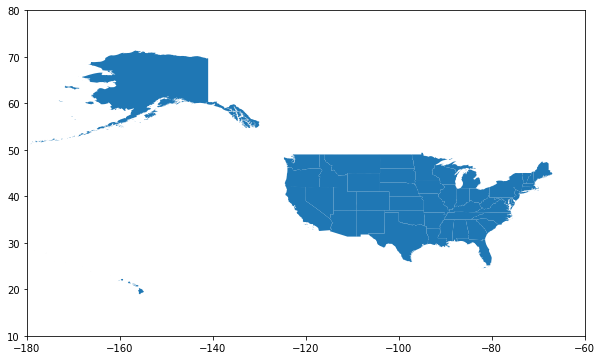

In [7]:
# Plot the dataset to ensure it has been collected properly
fig, ax = plt.subplots(figsize=(10, 10))
states51.plot(ax=ax)
ax.axis([-180, -60, 10, 80]);

### County Data

Collect and clean all geospatial for US counties (and the District of Columbia). This dataset includes each county's name, FIPS code, state FIPS code, and shapefiles.

In [8]:
# Import full dataset
county = gp.read_file("/content/drive/My Drive/MLPP Project/Data/county/tl_2017_us_county.shp")

# Combine county code with state FIP code to create a full County FIP code
county['code'] = [int("{:02.0f}{:03.0f}".format(int(s), int(c))) for s, c in zip(county.STATEFP, county.COUNTYFP)]

# Keep only relevant columns
county = county[['code', 'NAME', 'STATEFP', 'geometry']]
print('The dataset contains {0} counties.\n'.format(county.shape[0]))
county.head()

The dataset contains 3233 counties.



,code,NAME,STATEFP,geometry
0,31039,Cuming,31,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53069,Wahkiakum,53,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."
2,35011,De Baca,35,"POLYGON ((-104.56739 33.99757, -104.56772 33.9..."
3,31109,Lancaster,31,"POLYGON ((-96.91060 40.95841, -96.91060 40.958..."
4,31129,Nuckolls,31,"POLYGON ((-98.27367 40.08940, -98.27367 40.089..."


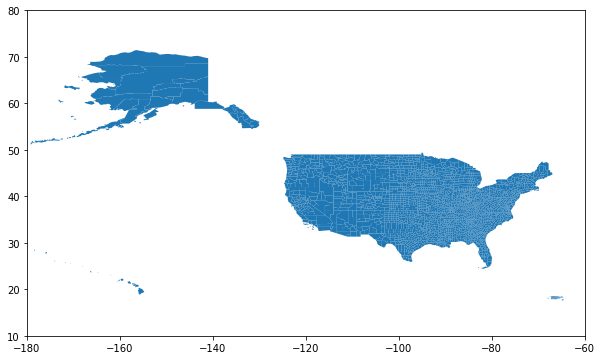

In [9]:
# Plot the dataset to ensure it has been collected properly
fig, ax = plt.subplots(figsize=(10, 10))
county.plot(ax=ax)
ax.axis([-180, -60, 10, 80]);

## Collect Demographics, Voter ID Law, and Voter Turnout Data

### Demographics Data

This [dataset](https://data.world/data4democracy/election-transparency/workspace/file?filename=CountyCharacteristics.csv) contains extensive demographic information for all counties in the US. The dataset is owned by [Data for Democracy](https://datafordemocracy.org/), a group whose mission is to "unite a functioning, enthusiastic network of individuals utilizing data to drive better choices and improve the world where we live". The dataset was compiled from the 2015 5-year ACS, but also includes data from the BEA, CDC, BLS, as well as a couple of other sources.  **(GGD: this is repeat text.)**

In [10]:
# Read in full dataset
demographic = pd.read_csv('https://query.data.world/s/5bcr4p3g7kskhdn5lk6mqf6xm5yjul')
demographic.head()

print('The table contains data for {0} counties.'.format(demographic.shape[0]))

The table contains data for 3141 counties.


Now that the dataset has been imported, let's create the metrics we will use in this study by manipulating the present features.

In [11]:
# Percentage of people with a college degree
demographic["CollegeDegree"] = (demographic["EdBachelorDegree"] + demographic["EdGraduateDegree"]) / (demographic["EdBachelorDegree"] + demographic["EdGraduateDegree"] + demographic["EdCollNoDegree"] + demographic["EdAssocDegree"])

# Interpolate to include 18 to 19 year olds, then get percentages of each age range
demographic["Age18_19"] = (demographic["Age15_19"] * 0.4).astype(int)
demographic["VEP"] = demographic[["Age18_19", "Age20_24", "Age25_34", "Age35_44", "Age45_54", "Age55_59", "Age60_64", "Age65_74", "Age75_84", "Age85"]].sum(axis=1)
demographic["34_younger"] = demographic[["Age18_19", "Age20_24", "Age25_34"]].sum(axis=1) / demographic["VEP"]
demographic["35_to_59"] = demographic[["Age35_44", "Age45_54", "Age55_59"]].sum(axis=1) / demographic["VEP"]
demographic["60_older"] = demographic[["Age60_64", "Age65_74", "Age75_84", "Age85"]].sum(axis=1) / demographic["VEP"]

# Percentage of people who are not white
demographic["not_white"] = 1 - demographic["WhiteAlone"] / demographic["TotalPopulation"]

# Percentage of people who are unemployed
demographic["unemployed"] = demographic["Unemployment"] / (demographic["Unemployment"] + demographic["Employment"])

# Keep only relevant columns
demographic = demographic[["County", "MedianHouseholdIncome", "CollegeDegree", "MedianAge", "34_younger", "35_to_59", "60_older", "VEP", "not_white", "unemployed"]]

# Let's look at a summary of the demographic data
demographic[["MedianHouseholdIncome", "CollegeDegree", "34_younger", "35_to_59", "60_older", "not_white", "unemployed"]].describe()

,MedianHouseholdIncome,CollegeDegree,34_younger,35_to_59,60_older,not_white,unemployed
count,3140.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000
mean,46824.208280,0.389428,0.268644,0.426047,0.305309,0.164664,0.048456
std,12248.256362,0.095485,0.058894,0.035019,0.061489,0.166202,0.018101
min,19328.000000,0.066667,0.065282,0.147255,0.062402,0.000000,0.013228
25%,38825.500000,0.324203,0.232472,0.408992,0.266941,0.045399,0.036037
50%,45094.500000,0.368727,0.261795,0.427984,0.302957,0.099402,0.045803
75%,52247.750000,0.437008,0.294107,0.445803,0.340597,0.228575,0.057677
max,123453.000000,0.873549,0.688351,0.585965,0.672983,0.952995,0.242399


### Voter ID Requirements Data

This [dataset](https://data.world/data4democracy/election-transparency/workspace/file?filename=States.csv) contains information regarding the voter ID law to which each state adheres. This dataset is also owned by Data for Democracy.

In [12]:
# Read in full dataset and keep relevant columns
voterID = pd.read_csv('https://query.data.world/s/or6s5unfzfbhcwsc66pmtoqltzccpw')[["State", "ElectoralVotes", "VoterIDLaw", "VoterIDLawVerbose"]]
voterID.head()

,State,ElectoralVotes,VoterIDLaw,VoterIDLawVerbose
0,1,9,3,Non-strict photo ID
1,2,3,2,Non-strict non-photo ID
2,4,11,4,Strict non-photo ID
3,5,6,2,Non-strict non-photo ID
4,6,55,1,No ID requirement


### Voter Turnout

This [dataset](https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-16/master/2016_US_County_Level_Presidential_Results.csv) contains the election results for the 2016 presidential election. This can be used to obtain the voter turnout rate. The dataset is owned by GitHub user [@tonmcg](https://github.com/tonmcg/US_County_Level_Election_Results_08-16/), founder and data scientist at [emdata.ai](https://linkedin.com/company/emdata/). The data was originally collected by [TownHall.com](https://townhall.com/election/2016/president/), a conservative website that "pulls together political commentary and analysis from over 100 leading columnists and opinion leaders, research from 100 partner organizations, conservative talk-radio and a community of millions of grassroots conservatives."  **(GGD: repeat text.)**

In [13]:
# Read in full dataset and grab appropriate columns
cols = ["total_votes", "state_abbr", "county_name", "combined_fips"]
turnout = pd.read_csv('https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-16/master/2016_US_County_Level_Presidential_Results.csv')[cols]

# Remove Alaska from dataframe due to its incorrect data
turnout = turnout[turnout["state_abbr"] != "AK"]

print('The table contains data for {0} counties.\n'.format(turnout.shape[0]))
turnout.head()

The table contains data for 3112 counties.



,total_votes,state_abbr,county_name,combined_fips
29,24661.0,AL,Autauga County,1001
30,94090.0,AL,Baldwin County,1003
31,10390.0,AL,Barbour County,1005
32,8748.0,AL,Bibb County,1007
33,25384.0,AL,Blount County,1009


This dataset contains the election results at the county level. However, Alaska only reported their results at the state level, so county-specific results are unavailable. For this reason, Alaska must be removed from this dataset.

### Combine all data

Now that the data has been collected and cleaned, we can merge the datasets with the shapefiles.

In [0]:
# Merge the demographic data with the county shapefiles
demgeo = county.merge(demographic, left_on="code", right_on="County").drop(columns="code")
demgeo.to_file('/content/drive/My Drive/MLPP Project/Data/demgeo.shp')

# Create a dataframe excluding Alaska and Hawaii (only to be used for plotting)
demgeo_mainland = demgeo[(demgeo["STATEFP"] != '02') & (demgeo["STATEFP"] != '15')]
demgeo_mainland.to_file('/content/drive/My Drive/MLPP Project/Data/demgeo_mainland.shp')

In [0]:
# Merge the voter ID laws data with the state shapefiles
votgeo = states51.merge(voterID, left_on="STATEFP", right_on="State")
votgeo.to_file('/content/drive/My Drive/MLPP Project/Data/votgeo.shp')

# Create a dataframe excluding Alaska and Hawaii (only to be used for plotting)
votgeo_mainland = votgeo[(votgeo["STATEFP"] != 2) & (votgeo["STATEFP"] != 15)]
votgeo_mainland.to_file('/content/drive/My Drive/MLPP Project/Data/votgeo_mainland.shp')

In [0]:
# Merge turnout data with county shapefiles
turngeo = county.merge(turnout, left_on='code', right_on='combined_fips')
turngeo.to_file('/content/drive/My Drive/MLPP Project/Data/turngeo.shp')

# Create a dataframe excluding Alaska and Hawaii (only to be used for plotting)
turngeo_mainland = turngeo[(turngeo["state_abbr"] != 'AK') & (turngeo["state_abbr"] != 'HI')]
turngeo.to_file('/content/drive/My Drive/MLPP Project/Data/turngeo_mainland.shp')

Note that a single county (Oglala Lakota County) in South Dakota is missing from the turnout dataset. When merging the datasets, the final county-level dataset will also be missing this county.

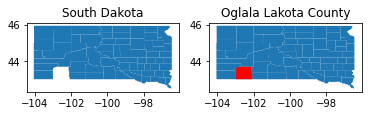

In [17]:
fig, ax = plt.subplots(1, 2)
turngeo[turngeo['state_abbr'] == 'SD'].plot(ax=ax[0])
county[county['STATEFP'] == '46'].plot(ax=ax[1]);
county[county['STATEFP'] == '46'].iloc[56:57].plot(ax=ax[1], facecolor='red');

ax[0].set_title('South Dakota')
ax[1].set_title('%s County' % county[county['STATEFP'] == '46']['NAME'].values[56])

fig.show();

In [21]:
# Merge county-specific data (demographics and voter turnout)
data = demgeo.merge(turngeo, on='geometry', how='inner')
data['turnout'] = data['total_votes'] / data['VEP']

# Merge state-specific data (voter ID requirements)
data['STATEFP'] = data["STATEFP_x"].astype(int)
data = data.merge(votgeo, on='STATEFP')

# Keep only relevant columns
cols = ['geometry_x', 'County', 'MedianHouseholdIncome', 'CollegeDegree',
        '34_younger', '35_to_59', '60_older', 'MedianAge', 'not_white', 'unemployed',
        'NAME_y', 'turnout', 'state_abbr', 'STATEFP', 'ElectoralVotes', 
        'VoterIDLaw', 'VoterIDLawVerbose', 'VEP']
data = data[cols]
data.rename(columns={"geometry_x":"geometry", "NAME_y":"county_name", "County":"county_fips"}, inplace=True)
data = gp.GeoDataFrame(data)
data.to_file('/content/drive/My Drive/MLPP Project/Data/data.shp')
data.head(3)

,geometry,county_fips,MedianHouseholdIncome,CollegeDegree,34_younger,35_to_59,60_older,MedianAge,not_white,unemployed,county_name,turnout,state_abbr,STATEFP,ElectoralVotes,VoterIDLaw,VoterIDLawVerbose,VEP
0,"POLYGON ((-97.01952 42.00410, -97.01952 42.004...",31039,50013.0,0.383511,0.236327,0.416655,0.347019,43.6,0.039987,0.031257,Cuming,0.578558,NE,31,5,1,No ID requirement,6893
1,"POLYGON ((-96.91060 40.95841, -96.91060 40.958...",31109,51830.0,0.517659,0.379476,0.393972,0.226552,32.9,0.126604,0.027886,Lancaster,0.573137,NE,31,5,1,No ID requirement,226478
2,"POLYGON ((-98.27367 40.08940, -98.27367 40.089...",31129,40488.0,0.337133,0.198129,0.392574,0.409297,49.2,0.020269,0.028924,Nuckolls,0.610261,NE,31,5,1,No ID requirement,3528


Create a version of the master dataset that excludes all Alaska data. This is important for analyses that are conducted at the county-level, for which Alaska data is not available.

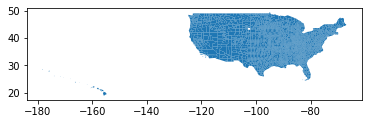

In [22]:
data_no_ak = data[data['state_abbr'] != 'AK']
data_no_ak.to_file('/content/drive/My Drive/MLPP Project/Data/data_no_ak.shp')
data_no_ak.plot();

Create a version of the master dataset that only includes states in the mainland US (i.e., excluding Alaska and Hawaii). This will only be used when creating geographic plots, as it is easier to capture just the mainland US than the entire US.

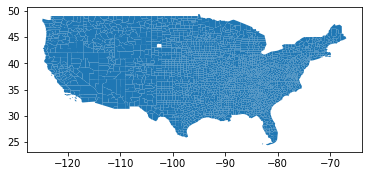

In [23]:
data_mainland = data_no_ak[data_no_ak['state_abbr'] != 'HI']
data_mainland.to_file('/content/drive/My Drive/MLPP Project/Data/data_mainland.shp')
data_mainland.plot();